Cluster Profiles:
              Credit amount   Duration        Age
Risk_Cluster                                     
0               7420.819048  38.057143  35.495238
1               2168.210127  16.343038  35.559494


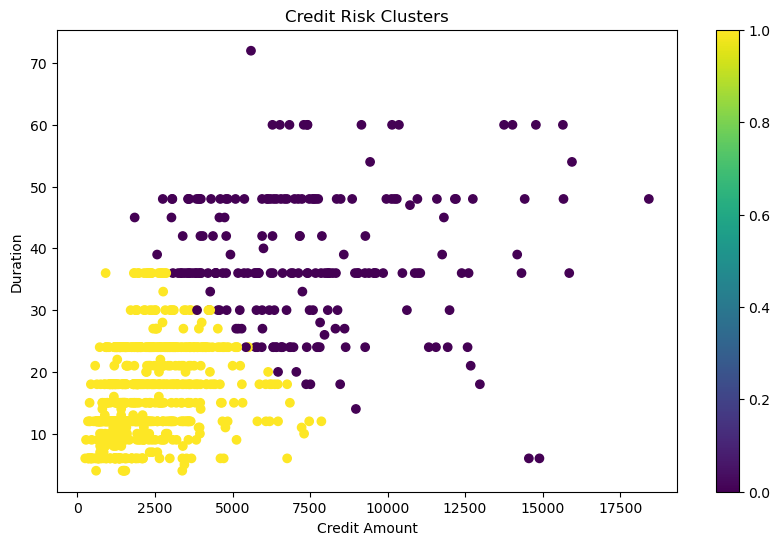

In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('german_credit_data.csv')

# Select features for clustering (excluding name/purpose for simplicity)
cluster_features = ['Age', 'Credit amount', 'Duration', 'Job']

# Preprocessing for clustering
numeric_features = ['Age', 'Credit amount', 'Duration']
categorical_features = ['Job']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Create pipeline
cluster_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('cluster', KMeans(n_clusters=2, random_state=42))
])

# Fit clustering
cluster_pipe.fit(df)
cluster_labels = cluster_pipe.predict(df)

# Add cluster labels to dataframe
df['Risk_Cluster'] = cluster_labels

# Analyze clusters to determine which is high/low risk
cluster_profile = df.groupby('Risk_Cluster').agg({
    'Credit amount': 'mean',
    'Duration': 'mean',
    'Age': 'mean'
})

print("Cluster Profiles:")
print(cluster_profile)

# Based on analysis, assign risk labels (0=good, 1=bad)
# Typically, higher credit amounts and longer durations indicate higher risk
if cluster_profile.loc[0, 'Credit amount'] > cluster_profile.loc[1, 'Credit amount']:
    df['Risk'] = df['Risk_Cluster'].map({0: 'bad', 1: 'good'})
else:
    df['Risk'] = df['Risk_Cluster'].map({0: 'good', 1: 'bad'})

# Visualize the clustering
plt.figure(figsize=(10, 6))
plt.scatter(df['Credit amount'], df['Duration'], c=df['Risk_Cluster'], cmap='viridis')
plt.xlabel('Credit Amount')
plt.ylabel('Duration')
plt.title('Credit Risk Clusters')
plt.colorbar()
plt.show()

# Save the labeled dataset
df.to_csv('german_credit_data.csv', index=False)

Classification Report:
              precision    recall  f1-score   support

         bad       0.98      0.93      0.95        54
        good       0.98      1.00      0.99       246

    accuracy                           0.98       300
   macro avg       0.98      0.96      0.97       300
weighted avg       0.98      0.98      0.98       300


Confusion Matrix:
[[ 50   4]
 [  1 245]]


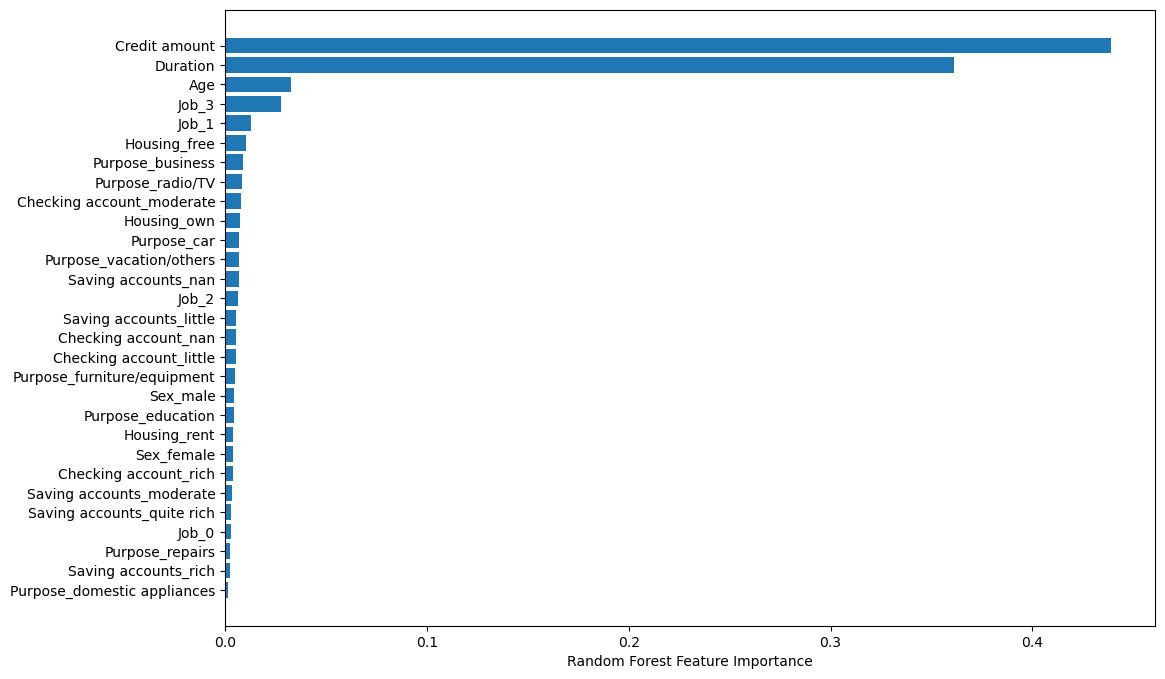

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Prepare features and target
X = df.drop(['Risk', 'Risk_Cluster'], axis=1)
y = df['Risk']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Preprocessing pipeline for supervised learning
numeric_features = ['Age', 'Credit amount', 'Duration']
categorical_features = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Job']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Random Forest classifier
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ))
])

# Train model
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
importances = rf.named_steps['classifier'].feature_importances_
feature_names = numeric_features + list(rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))

# Plot feature importances
plt.figure(figsize=(12, 8))
sorted_idx = importances.argsort()
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()


Risk Profile Analysis:
            Age  Credit amount   Duration  Job
Risk                                          
bad   35.495238    7420.819048  38.057143    2
good  35.559494    2168.210127  16.343038    2


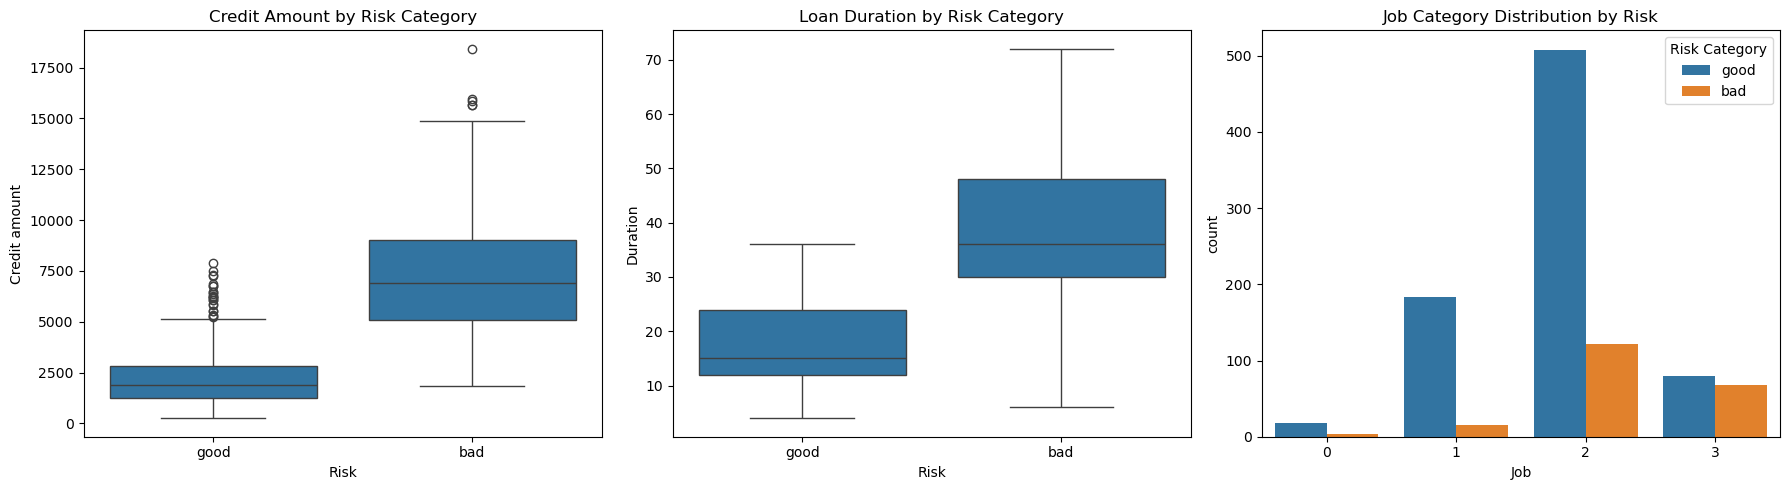

In [11]:
# Analyze the relationship between original features and risk labels
risk_profile = df.groupby('Risk').agg({
    'Age': 'mean',
    'Credit amount': 'mean',
    'Duration': 'mean',
    'Job': lambda x: x.mode()[0]
})

print("\nRisk Profile Analysis:")
print(risk_profile)

# Visualize key relationships
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='Risk', y='Credit amount', data=df, ax=axes[0])
axes[0].set_title('Credit Amount by Risk Category')

sns.boxplot(x='Risk', y='Duration', data=df, ax=axes[1])
axes[1].set_title('Loan Duration by Risk Category')

sns.countplot(x='Job', hue='Risk', data=df, ax=axes[2])
axes[2].set_title('Job Category Distribution by Risk')
axes[2].legend(title='Risk Category')

plt.tight_layout()
plt.show()

In [12]:
# Step 3: Save the model and preprocessor
# Save the entire pipeline (including preprocessor)
joblib.dump(rf, 'credit_risk_model.pkl')

# Save the preprocessor separately (needed for feature importance analysis)
joblib.dump(preprocessor, 'preprocessor.pkl')

print("Model and preprocessor saved successfully!")
print(f"Model saved as: credit_risk_model.pkl")
print(f"Preprocessor saved as: preprocessor.pkl")

# Optional: Save the labeled dataset
df.to_csv('german_credit_labeled.csv', index=False)
print("Labeled dataset saved as: german_credit_labeled.csv")

Model and preprocessor saved successfully!
Model saved as: credit_risk_model.pkl
Preprocessor saved as: preprocessor.pkl
Labeled dataset saved as: german_credit_labeled.csv
